In [1]:
ENV["PYTHONPATH"] = "/home/gridsan/aligho/.local/lib/python3.8/site-packages/PyNormaliz-2.15-py3.8-linux-x86_64.egg";
D = 2;
using HDF5, PyPlot
using DelimitedFiles, PyPlot, LinearAlgebra, JLD2, PyCall, StaticArrays, Statistics
using Crystalline, Brillouin, MPBUtils, SymmetryBases
using Crystalline: TEST_αβγs, TEST_αβγ, dot, norm
using Crystalline: normscale, matching_littlegroups
using Crystalline: AbstractFourierLattice
topology_paper_dir = "../../TopologyPaper/"
include(topology_paper_dir * "get-freqs-symeigs.jl")
include(topology_paper_dir * "symeigs-from-io.jl");
include("../../Topology_ML/Phc_ML/fft.jl")
include("../get_uc_coefs.jl");
np = pyimport("numpy");

In [23]:
dir = "./inverse_design_smooth_symbols_random/output/sg2/tm/";

In [24]:
filename = "sg2-tm.jld2";
loaded_data = load(dir * filename);

In [25]:
N = 250 # Number of inverse designed examples per topological class
symmetries = [[x[1].n for x in loaded_data["summariesv"][1+topological_class*N:(topological_class+1)*N]] for topological_class in range(0, 7)];
# symmetries stores the first band symmetry vector delineated by class

In [26]:
ns = [[0, 1, 0, 1, 0, 1, 1, 0, 1], [0, 1, 1, 0, 0, 1, 1, 0, 1], 
[0, 1, 0, 1, 1, 0, 1, 0, 1], [0, 1, 1, 0, 1, 0, 1, 0, 1], [1, 0, 0, 1, 0, 1, 1, 0, 1], 
[1, 0, 1, 0, 0, 1, 1, 0, 1], [1, 0, 0, 1, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0, 1, 0, 1]];

In [27]:
# Success rate for smooth lattices
num_correct_per_class = [count(x -> x == ns[topological_class], symmetries[topological_class]) for topological_class in range(1,8)]

8-element Vector{Int64}:
 250
 250
 250
 250
 250
 250
 250
 250

In [28]:
smooth_accuracy_symbols = 100;

In [29]:
# Find which ones we expected to be correct
dir = "inverse_design_two_tone_symbols_random/";
expect_to_be_good = []
for n in range(0, 7)
    filename = "two_tone_scores-class$(n).h5"
    f = h5open(dir * filename, "r")
    which_good = findall(x-> x == n, np.argmax(f["two_tone_classifications"][], axis=0))
    push!(expect_to_be_good, which_good)
end

In [30]:
dir = "./inverse_design_two_tone_symbols_random/output/sg2/tm/";
filename = "sg2-tm.jld2";
loaded_data = load(dir * filename);

In [31]:
N = 250
symmetries = [[x[1].n for x in loaded_data["summariesv"][1+topological_class*N:(topological_class+1)*N]] for topological_class in range(0, 7)];

In [32]:
num_correct_per_class = [count(x -> x == ns[topological_class], symmetries[topological_class][expect_to_be_good[topological_class]]) for topological_class in range(1,8)]

8-element Vector{Int64}:
 198
 243
 212
 212
 216
 221
 234
 229

In [33]:
# Two tone accuracy
two_tone_accuracy_symbols = 100 * sum(num_correct_per_class)/sum(length.(expect_to_be_good))

99.66120835686053

In [34]:
# Now we change contrast
loaded_data_v = []
for contrast_idx in 1:6
    contrast_dir = "./inverse_design_two_tone_symbols_random/changing_contrast/output/sg2/tm/contrast$(contrast_idx)/"
    filename = "sg2-tm-contrast$(contrast_idx).jld2";
    loaded_data = load(contrast_dir * filename);
    push!(loaded_data_v, loaded_data)
end

In [38]:
N = 250
symmetries_v = [[[x[1].n for x in loaded_data_v[contrast_idx]["summariesv"][1+topological_class*N:(topological_class+1)*N]] for topological_class in range(0, 7)] for contrast_idx in range(1, 6)];

In [39]:
num_correct_per_class = [[100*count(x -> x == ns[topological_class], symmetries[topological_class][expect_to_be_good[topological_class]]) for topological_class in range(1,8)] for symmetries in symmetries_v]

6-element Vector{Vector{Int64}}:
 [19200, 24300, 21200, 20700, 21800, 21800, 22700, 23000]
 [17800, 24300, 21200, 19500, 21800, 21500, 19500, 23000]
 [16900, 24300, 21200, 19100, 21800, 20900, 19300, 23000]
 [16500, 24300, 21200, 18800, 21800, 20700, 19300, 23000]
 [16400, 24300, 21200, 18700, 21800, 20600, 19200, 23000]
 [16100, 24300, 21200, 18600, 21800, 20600, 19100, 23000]

In [40]:
contrast_accuracy_symbols = [sum(num_correct_per_class[n])/sum(length.(expect_to_be_good)) for n in 1:6]

6-element Vector{Float64}:
 98.64483342744212
 95.20045172219085
 94.01468097120271
 93.50649350649351
 93.28063241106719
 92.9983060417843

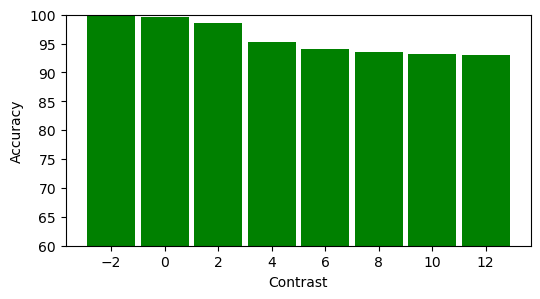

In [42]:
figure(figsize=(6, 3))
bar(-2:2:12, [smooth_accuracy_symbols, two_tone_accuracy_symbols, contrast_accuracy_symbols...], color="green", width=1.8)
ylabel("Accuracy")
xlabel("Contrast")
ylim(60, 100);
#savefig("./figures/inverse_design_accuracy_symbols_random.pdf")